# Вооруженные грабежи в Бостоне
[Список рядов](https://docs.google.com/spreadsheets/d/1NXTSQfIkAAHHnslrOVb2e0syP3Q3SHz0oZ_7qVor5Lg/edit#gid=0)

<!-- Использовать модели класса ARIMA -->

До 14 декабря 2017, 23:59.

Известно [ежемесячное число вооруженных грабежей в Бостоне с января 1966 по октябрь 1975](https://datamarket.com/data/set/22ob/monthly-boston-armed-robberies-jan1966-oct1975-deutsch-and-alt-1977#!ds=22ob&display=line). Необходимо построить прогноз на следующие три года.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import warnings
from itertools import product

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['figure.figsize'] = (10,5)
plt.rc('font', family='Arial')
plt.style.use('classic')

C:\Users\Dmitry\Miniconda3\envs\ml\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

Загружаем данные monthly-boston-armed-robberies-j.csv, парсим даты.

In [3]:
TITLE = "monthly Boston armed robberies"

In [4]:
df = pd.read_csv(r"monthly-boston-armed-robberies-j.csv", names=("month", "crimes"),
                 index_col=["month"], engine="python", skipfooter=(2), skiprows=(1), 
                 parse_dates=["month"])
df.head().T
df.tail().T
df.shape

month   1966-01-01  1966-02-01  1966-03-01  1966-04-01  1966-05-01
crimes          41          39          50          40          43

month   1975-06-01  1975-07-01  1975-08-01  1975-09-01  1975-10-01
crimes         316         398         394         431         431

(118, 1)

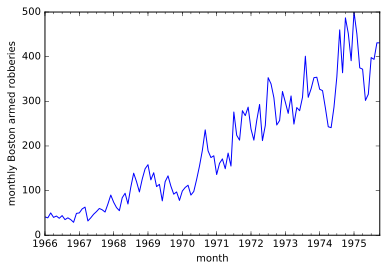

In [5]:
_ = df.crimes.plot()
_ = plt.ylabel(TITLE)

> По графику сразу видно, что ряд не является стационарным.

Проверка стационарности и STL-декомпозиция ряда:

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [7]:
def fulerprint(y):
    fuler = adfuller(y)
    
    print(f"Критерий Дики-Фуллера: p={fuler[1]:.5}")
    
    if fuler[0] > fuler[4]['5%']:
        print("Ряд имеет единичные корни")

In [8]:
def ssnplot(y, fuler=True):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    _ = seasonal_decompose(y).plot()
    
    if fuler:
        fulerprint(y)

Критерий Дики-Фуллера: p=0.99428
Ряд имеет единичные корни


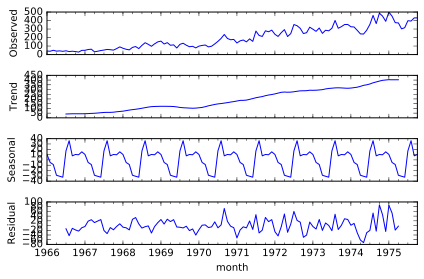

In [9]:
ssnplot(df.crimes)

> Ряд нестационарен: 
* pvalue теста Дики-Фуллера для ряда $\to$ 1;
* ряд имеет неубывающий, практически линейный тренд;
* имеются единичные корни.

> Сезоном для данного ряда является промежуток в 12 месяцев.

In [10]:
SEASON = 12
NLAGS = 48

> Функция для отображения исходного ряда и ACF, PACF.

> Код функции взят [из статьи](https://habrahabr.ru/company/ods/blog/327242/).

In [11]:
def tsplot(y, lags=None, fuler=True):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    _ = y.plot(ax=ts_ax)
    _ = ts_ax.set_title('Time Series Analysis Plots')
    _ = smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    _ = smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
    _ = plt.tight_layout()
    
    if fuler:
        fulerprint(y)

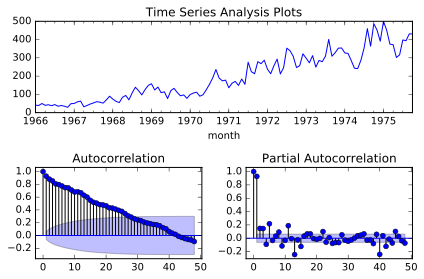

In [12]:
tsplot(df.crimes, lags=NLAGS, fuler=False)

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Критерий Дики-Фуллера: p=0.79566
Ряд имеет единичные корни
Оптимальный параметр преобразования Бокса-Кокса: 0.31678


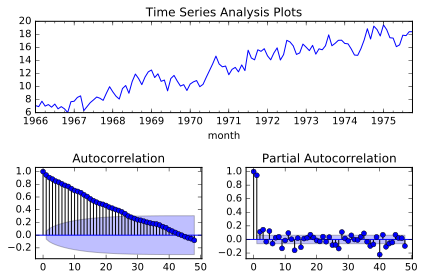

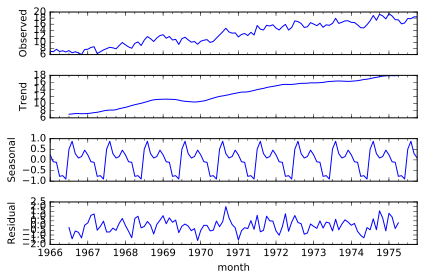

In [13]:
df['crimes_box'], lmbda = stats.boxcox(df.crimes)

tsplot(df.crimes_box, lags=NLAGS)
ssnplot(df.crimes_box, fuler=False)

print(f"Оптимальный параметр преобразования Бокса-Кокса: {lmbda:.6}")

> Ряд по-прежднему не стационарен.

### Стационарность

Что с гипотезей нестационарности и трендом?
Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.067066
Ряд имеет единичные корни


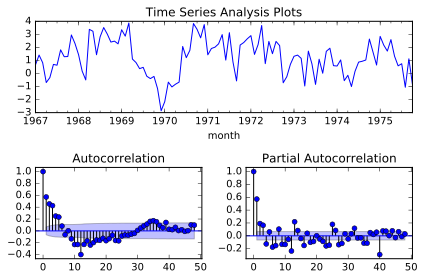

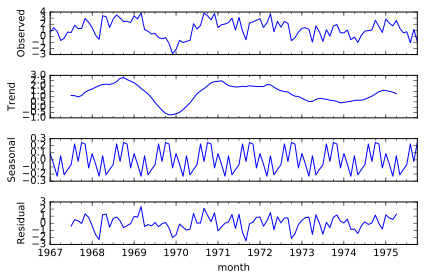

In [14]:
df['crimes_box_ssn'] = df.crimes_box.diff(SEASON)

tsplot(df.crimes_box_ssn[SEASON:], lags=NLAGS)
ssnplot(df.crimes_box_ssn[SEASON:], fuler=False)

> Тренд ряда убран.

Что с гипотезей нестационарности и трендом?
Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=1.265e-06


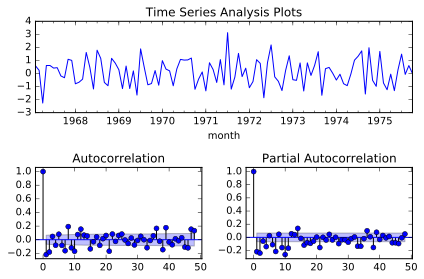

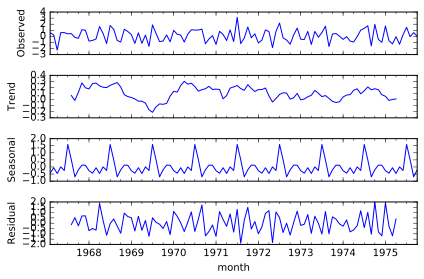

In [15]:
df['crimes_box_ssn_diff'] = df.crimes_box.diff(1)

tsplot(df.crimes_box_ssn_diff[SEASON+1:], lags=NLAGS)
ssnplot(df.crimes_box_ssn_diff[SEASON+1:], fuler=False)

> Гипотеза нестационарности для интегрированного ряда 13 порядка отвергается, тренд отсутствует.

> Попробуем провести только дифференцирование первого порядка без сезонного.

Критерий Дики-Фуллера: p=3.3922e-07


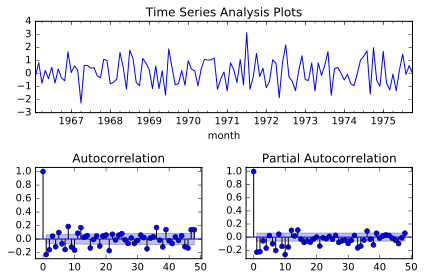

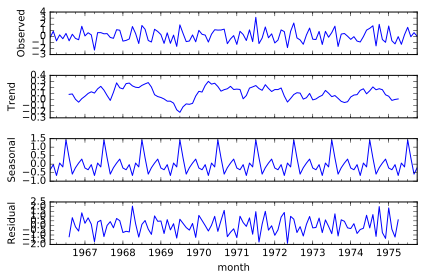

In [16]:
df['crimes_box_diff'] = df.crimes_box.diff(1)

tsplot(df.crimes_box_diff[1:], lags=NLAGS)
ssnplot(df.crimes_box_diff[1:], fuler=False)

> В результате получен интегрированный ряд первого порядка ([источник](https://habrahabr.ru/post/207160/)).

In [17]:
BIAS = 1

Принимаем ли гипотезу нестационарности?

> Полученный результат отвергает гипотезу нестационарности:
* pvalue критерия Дики-Фуллера $\to$ 0;
* число значимых компонент ACF, PACF == 1;
* отсутствует тренд;
* ряд не имеет единичных корней.

## Подбор модели

Начальные приближения: Q=1, q=2, P=1, p=4

In [18]:
ps = range(0, 5)
d = BIAS  # порядок интегрированного ряда
qs = range(0, 3)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

In [20]:
def find_best_model(model_class, y, parameters):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    results = []
    best_aic = float("inf")
    best_model = None
    best_param = None
    
    warnings.filterwarnings('ignore')
    for idx, param in enumerate(parameters):
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model = model_class(y, param)
            model = model.fit()
        except ValueError:
            print(f"{idx}\twrong parameters:\t{param}")
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    warnings.filterwarnings('default')
    
    return best_model, results, best_param

> На случай, если потребуется обучать другие модели.

In [21]:
def sarimax_model(y, params):
    return SARIMAX(y, order=(params[0], BIAS, params[1]), 
                   seasonal_order=(params[2], D, params[3], SEASON))

In [22]:
%%time

sarimax_bmdl, sarimax_res, sarimax_bprm = find_best_model(sarimax_model, 
                                                          df.crimes_box, 
                                                          parameters_list)

0	wrong parameters:	(0, 0, 0, 0)
20	wrong parameters:	(1, 2, 0, 0)
21	wrong parameters:	(1, 2, 0, 1)
22	wrong parameters:	(1, 2, 1, 0)
23	wrong parameters:	(1, 2, 1, 1)
44	wrong parameters:	(3, 2, 0, 0)
45	wrong parameters:	(3, 2, 0, 1)
46	wrong parameters:	(3, 2, 1, 0)
47	wrong parameters:	(3, 2, 1, 1)
56	wrong parameters:	(4, 2, 0, 0)
57	wrong parameters:	(4, 2, 0, 1)
58	wrong parameters:	(4, 2, 1, 0)
59	wrong parameters:	(4, 2, 1, 1)
Wall time: 21.3 s


In [23]:
sarimax_res_tbl = pd.DataFrame(sarimax_res, columns=['parameters', 'aic'])
sarimax_res_tbl.sort_values(by='aic', ascending=True).head().T

20            4             16            24  \
parameters  (2, 0, 0, 1)  (0, 1, 0, 1)  (1, 1, 0, 1)  (2, 1, 0, 1)   
aic               295.51       295.537       296.417       296.592   

                      8   
parameters  (0, 2, 0, 1)  
aic              296.601

Лучшая модель:

In [24]:
sarimax_bmdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         crimes_box   No. Observations:                  118
Model:             SARIMAX(2, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -143.755
Date:                            Wed, 13 Dec 2017   AIC                            295.510
Time:                                    22:52:15   BIC                            306.593
Sample:                                01-01-1966   HQIC                           300.010
                                     - 10-01-1975                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4105      0.108     -3.800      0.000      -0.622      -0.199
ar.L2         -0.2695      0.098     -2.759      0.006      -0.461      -0.078
ma.S.L12      -0.9140      0.296     -3.090      0.002      -1.494      -0.334
sigma2         0.7509      0.189      3.972      0.000       0.380       1.121
===================================================================================
Ljung-Box (Q):                       38.97   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.52   Prob(JB):                         0.67
Heteroskedasticity (H):               1.00   Skew:                             0.20
Prob(H) (two-sided):                  1.00   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Её остатки:

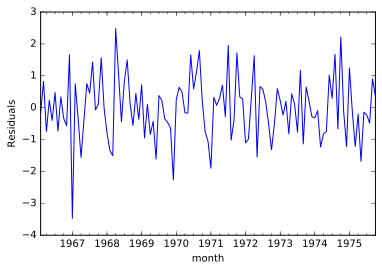

Критерий Дики-Фуллера: p=4.888e-07
Критерий Стьюдента: p=0.845954


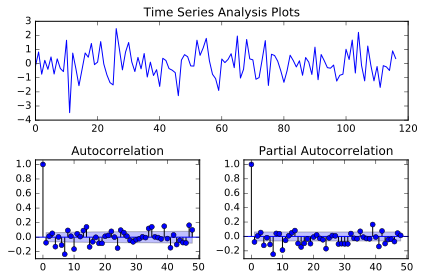

In [25]:
_ = sarimax_bmdl.resid[BIAS:].plot()
_ = plt.ylabel(u'Residuals')
_ = plt.show()

tsplot(sarimax_bmdl.resid[BIAS:].values.squeeze(), lags=NLAGS)

print(f"Критерий Стьюдента: p={stats.ttest_1samp(sarimax_bmdl.resid[BIAS:], 0)[1]:.6}")

Остатки стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

In [26]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y + 1)/lmbda))

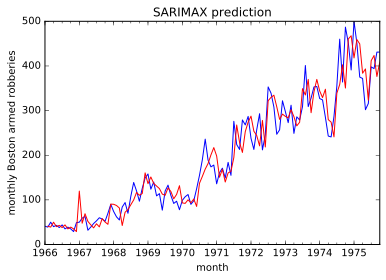

In [27]:
df['sarimax'] = invboxcox(sarimax_bmdl.fittedvalues, lmbda)

_ = df.crimes.plot()
_ = df.sarimax[BIAS:].plot(color='r')
_ = plt.title("SARIMAX prediction")
_ = plt.ylabel(TITLE)

### Прогноз

In [28]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

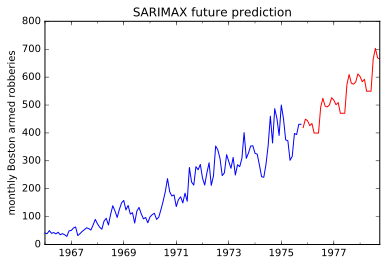

In [30]:
crimes = df[['crimes']]
date_list = [
    datetime.strptime("1975-11-01", "%Y-%m-%d") + relativedelta(months=x) 
    for x in range(3 * SEASON)
]

future = pd.DataFrame(index=date_list, columns=crimes.columns)
crimes = pd.concat([crimes, future])
crimes['forecast'] = invboxcox(sarimax_bmdl.predict(start=118, end=154), lmbda)
_ = crimes.crimes.plot()
_ = crimes.forecast.plot(color='r')
_ = plt.title("SARIMAX future prediction")
_ = plt.ylabel(TITLE)